In [1]:
####################
#
# Initialization
#
####################

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch

from drawinganalyses.config import (
    LOCAL_DATA_DIR,
    DATASET_NAME,
    MODELS_STORAGE,
    ANNOTATION_FILE,
    MODEL_NAME,
    label_to_str
)
from drawinganalyses.datasets.drawings_pytorch import DrawingDataset
from drawinganalyses.utils.visualization import imshow, visualize_model

cudnn.benchmark = True
plt.ion()   # interactive mode

/home/emaitre/miniconda3/envs/MADE/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
# Trained Resnet18 as a feature embedder
---

In [2]:
# Some parameters for our loaders

# Putting it here because of transforms.Resize()
# However, the anti-aliases parameter should be addressed in the future
# For now, it induces a bug in the masks for Captum
import warnings
warnings.filterwarnings("ignore")


batch_size=4
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((256, 256),)])

In [3]:
generator1 = torch.Generator().manual_seed(42) # Seed fixed for reproducibility
dataset = DrawingDataset(
    dataset_name=DATASET_NAME,
    annotations_file=ANNOTATION_FILE,
    data_dir=LOCAL_DATA_DIR,
    label_to_str=label_to_str,
    transform=transform)
# Splitting into train, valid, test randomly (but fixed since seed is fixed)
trainset, valset, testset = random_split(dataset, [0.8, 0.1, 0.1], generator=generator1)

                                 name  label
0       Wintermolly20080216000001.jpg      3
1       Springmolly20100414000001.jpg      1
2       Wintermolly20090115000001.jpg      3
3       Springmolly20090521000001.jpg      1
4       Autumnmolly20061218000002.jpg      0
...                               ...    ...
1294    Summermolly20090812000002.jpg      2
1295    Autumnmolly20071118000001.jpg      0
1296    Wintermolly20080202000002.jpg      3
1297    Springmolly20090601000001.jpg      1
1298  Wintermolly20070302000001_2.jpg      3

[1299 rows x 2 columns]


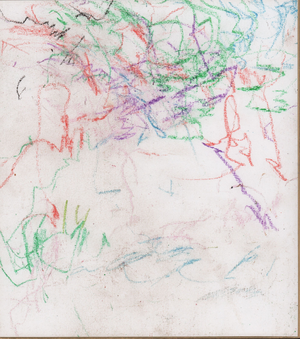

'Drawing name : Wintermolly20080216000001.jpg, label : Winter'

In [4]:
dataset.show(0)

In [5]:
trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=2)
valloader = torch.utils.data.DataLoader(
    valset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=1,
    shuffle=True,
    num_workers=2)

dataloaders={'train':trainloader, 'val':valloader, 'test':testloader}
dataset_sizes={'train':len(trainloader)*batch_size, 'val':len(valloader)*batch_size, 'test':len(testloader)*batch_size}


In [6]:
# Some useful parameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names = list(label_to_str.values())


In [ ]:
# Loading of the pretrained model

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)
model.load_state_dict(torch.load(MODELS_STORAGE / MODEL_NAME))
model.eval()
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
feature_extractor.eval()

In [8]:
outputs = torch.zeros((len(testloader), 512))
labels = []
names = []
# Inference and formating of an example from the test set
for idx, (input, label, name) in enumerate(iter(testloader)):
    true_label = label_to_str[label.item()]
    labels.append(true_label)
    names.append(name[0])
    output = feature_extractor(input)
    squeezed_tensor = output.squeeze(dim=2).squeeze(dim=2)[0]
    outputs[idx] = squeezed_tensor
    

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

In [10]:
X = outputs.detach().numpy()

In [11]:
similarity_matrix = cosine_similarity(X)

In [12]:
import networkx as nx


In [13]:
G_similarities = nx.from_numpy_array(similarity_matrix)

# Suppression des edges dont le poids est inférieur au threshold et visualisation du nouveau graph

partition = nx.community.louvain_communities(G_similarities)


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)
tsne.kl_divergence_

In [15]:
import plotly.express as px

fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=labels, hover_name=names)
fig.update_layout(
    title="t-SNE visualization of Custom Classification dataset",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [17]:
fig = px.scatter(x=X_pca[:, 0], y=X_pca[:, 1], color=labels, hover_name=names)
fig.update_layout(
    title="PCA visualization of Representation of Molly drawings",
    xaxis_title="First Principal Component",
    yaxis_title="Second Principal Component",
)
fig.show()

In [18]:
map_partitions = []
for part in partition:
    sous_part = []
    for index in part:
        sous_part.append(names[index])
    map_partitions.append(sous_part)

---
# PCA and T-SNE Directly on the images
---

In [39]:
images = []
labels = []
names = []
for image, label, name in iter(dataset):
    images.append(image)
    labels.append(label_to_str[label.item()])
    names.append(name)

In [40]:
for idx, img in enumerate(images):
    img_flattened = img.reshape(-1)
    images[idx] = img_flattened

In [41]:
images = np.asarray(images)

---
### 1D
---

In [42]:
pca = PCA(n_components=1)
X_pca = pca.fit_transform(images)

In [43]:
fig = px.scatter(x=X_pca[:, 0], y=np.zeros(1299),color=labels, hover_name=names)
fig.show()

In [44]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.44069067]


---
# 3D
---

In [45]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(images)

In [46]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.44069067 0.05271254 0.02653586]


In [47]:
fig = px.scatter_3d(x=X_pca[:, 0], y=X_pca[:, 1], z=X_pca[:, 2],
              color=labels, hover_name=names)
fig.show()

In [ ]:
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(images)


In [50]:
tsne.kl_divergence_

2.0689432621002197

In [49]:
fig = px.scatter_3d(x=X_tsne[:, 0], y=X_tsne[:, 1], z=X_tsne[:, 2],
    color=labels, hover_name=names)
fig.show()